# Kalman Filter

In [1]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise


In [2]:
%matplotlib inline

In [18]:
def run_kalman_filter_and_predict(batch_positions):
    """
    Applies Kalman Filter to the first 5 timesteps to predict the next 10 timesteps.
    
    Args:
        batch_positions: A numpy array of shape (batch_size, 15, 3)
                         containing the 3D positions.
                         
    Returns:
        A numpy array of shape (batch_size, 15, 6) containing the
        predicted states (position and velocity) for each timestep in each batch.
    """
    batch_size, timesteps, _ = batch_positions.shape
    assert timesteps == 15, "The input should have 15 timesteps per sequence."
    
    predictions = np.zeros((batch_size, 15, 6))
    
    for i in range(batch_size):
        # Time step
        dt = 0.4
        
        # Create a KalmanFilter instance
        kf = KalmanFilter(dim_x=6, dim_z=3)
        
        # State Transition matrix A
        kf.F = np.array([[1, 0, 0, dt, 0, 0],
                         [0, 1, 0, 0, dt, 0],
                         [0, 0, 1, 0, 0, dt],
                         [0, 0, 0, 1, 0, 0],
                         [0, 0, 0, 0, 1, 0],
                         [0, 0, 0, 0, 0, 1]])
        
        # Measurement matrix H
        kf.H = np.array([[1, 0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 0, 0],
                         [0, 0, 1, 0, 0, 0]])
        
        # Initial state covariance
        kf.P *= 1
        
        # Process noise covariance
        q = Q_discrete_white_noise(dim=3, dt=dt, var=10)
        kf.Q = block_diag(q, q)
        print(kf.Q)
        #kf.Q = np.eye(6) * 0.1
        
        # Measurement noise covariance
        kf.R = np.eye(3) * 0.1
        
        # Initial state (starting with the first position and zero velocity)
        initial_position = batch_positions[i, 0]
        kf.x = np.array([initial_position[0], initial_position[1], initial_position[2], 0, 0, 0])
        
        # Running the Kalman Filter for the first 5 timesteps
        for t in range(5):
            z = batch_positions[i, t]
            kf.predict()
            kf.update(z)
            predictions[i, t] = kf.x
        
        # Predicting the next 10 timesteps without updating
        for t in range(5, 15):
            kf.predict()
            predictions[i, t] = kf.x
    
    return predictions

constant acceleration model included

In [11]:
def run_kalman_filter_and_predict_ca(batch_positions):
    """
    Applies Kalman Filter to the first 5 timesteps to predict the next 10 timesteps.
    
    Args:
        batch_positions: A numpy array of shape (batch_size, 15, 3)
                         containing the 3D positions.
                         
    Returns:
        A numpy array of shape (batch_size, 15, 9) containing the
        predicted states (position, velocity, and acceleration) for each timestep in each batch.
    """
    batch_size, timesteps, _ = batch_positions.shape
    assert timesteps == 15, "The input should have 15 timesteps per sequence."
    
    predictions = np.zeros((batch_size, 15, 9))
    
    for i in range(batch_size):
        # Time step
        dt = 1.0
        
        # Create a KalmanFilter instance
        kf = KalmanFilter(dim_x=9, dim_z=3)
        
        # State Transition matrix A (constant acceleration model)
        kf.F = np.array([[1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0],
                         [0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0],
                         [0, 0, 1, 0, 0, dt, 0, 0, 0.5*dt**2],
                         [0, 0, 0, 1, 0, 0, dt, 0, 0],
                         [0, 0, 0, 0, 1, 0, 0, dt, 0],
                         [0, 0, 0, 0, 0, 1, 0, 0, dt],
                         [0, 0, 0, 0, 0, 0, 1, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 1, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 1]])
        
        # Measurement matrix H
        kf.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 1, 0, 0, 0, 0, 0, 0]])
        
        # Initial state covariance
        kf.P *= 10
        
        # Process noise covariance
        kf.Q = np.eye(9) * 0.1
        
        # Measurement noise covariance
        kf.R = np.eye(3) * 1.0
        
        # Initial state (starting with the first position, estimated velocity, and zero acceleration)
        initial_position = batch_positions[i, 0]
        initial_velocity = (batch_positions[i, 1] - batch_positions[i, 0]) / dt
        initial_acceleration = np.zeros(3)
        kf.x = np.hstack((initial_position, initial_velocity, initial_acceleration))
        
        # Running the Kalman Filter for the first 5 timesteps
        for t in range(5):
            z = batch_positions[i, t]
            kf.predict()
            kf.update(z)
            predictions[i, t] = kf.x
        
        # Predicting the next 10 timesteps without updating
        for t in range(5, 15):
            kf.predict()
            predictions[i, t] = kf.x
    
    return predictions

In [4]:
def plot_predictions(batch_positions, predictions, sample_index=0):
    """
    Plots the ground truth vs predicted positions.
    
    Args:
        batch_positions: A numpy array of shape (batch_size, 15, 3) containing the ground truth positions.
        predictions: A numpy array of shape (batch_size, 15, 6) containing the predicted states.
        sample_index: The index of the sample to plot (default is 0).
    """
    ground_truth = batch_positions[sample_index]
    predicted_positions = predictions[sample_index, :, :3]  # Get only the position components
    
    plt.figure(figsize=(12, 6))
    plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'bo-', label='Ground Truth')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], 'ro--', label='Predicted')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ground Truth vs Predicted Positions for Sample {sample_index}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
import tensorflow as tf 
loaded = tf.data.experimental.load(
    "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_orig"
)
def tf_dataset_to_numpy(tf_dataset):
    numpy_data = []
    for batch in tf_dataset.as_numpy_iterator():
        if batch[0].shape[0]==32:
            numpy_data.append(batch[0])
    return np.asarray(numpy_data)*100

# Convert the TensorFlow dataset to a numpy array
batch_positions = tf_dataset_to_numpy(loaded)

2024-08-25 20:39:22.272884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-25 20:39:22.945810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


2024-08-25 20:39:24.527122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-25 20:39:24.542974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-25 20:39:24.543658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-25 20:39:24.545788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-25 20:39:24.546379: I tensorflow/compile

In [7]:
batch_positions.shape

(552, 32, 15, 3)

In [12]:
index = 7
predictions = run_kalman_filter_and_predict_ca(batch_positions[0][index:])
plot_predictions(batch_positions[0][index:], predictions)

ValueError: dim must be between 2 and 4

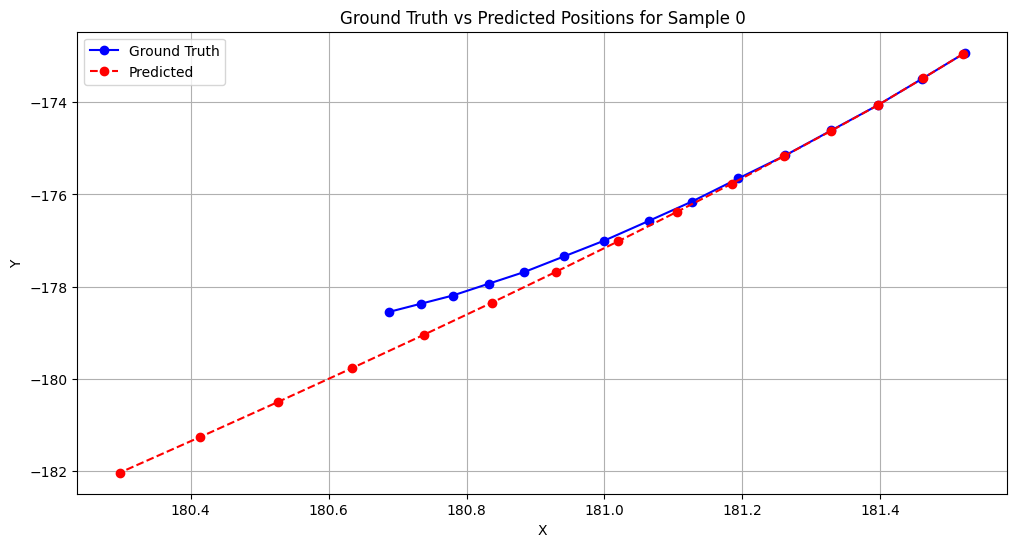

In [12]:
index = 2
predictions = run_kalman_filter_and_predict_ca(batch_positions[0][index:])
plot_predictions(batch_positions[0][index:], predictions)

# Particle Filter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.monte_carlo import systematic_resample
from numpy.random import uniform, normal

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from imm import *
from simple_kalman import *
from bayes import *

2024-08-28 11:31:48.802081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 11:31:49.964433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
ds_2d = load_dataset("/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_aug", batch_size=32, pos_dim=2)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


2024-08-28 11:32:08.410423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 11:32:08.559731: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 11:32:08.560200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 11:32:08.562967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 11:32:08.563406: I tensorflow/compile

In [170]:
import numpy as np
from scipy.stats import norm
from numpy.random import uniform, normal

class IMMParticleFilter:
    def __init__(self, num_particles, state_dim, measurement_dim):
        self.num_particles = num_particles
        self.state_dim = state_dim
        self.measurement_dim = measurement_dim
        
        # Particles and weights for each model
        self.particles_cv = np.zeros((num_particles, state_dim))
        #self.particles_ctrv = np.zeros((num_particles, state_dim))
        self.weights_cv = np.ones(num_particles) / num_particles
        #self.weights_ctrv = np.ones(num_particles) / num_particles

        # Process and measurement noise
        self.process_noise_cv = 0.4
        #self.process_noise_ctrv = 0.4
        self.measurement_noise = 0.2
        self.dt = 0.4

        # Transition probabilities between models
        #self.transition_probs = np.array([[0.8, 0.2],
                                          #[0.2, 0.8]])

    def create_uniform_particles(self, x_range, y_range, vx_range, vy_range, omega_range):
        for model_particles in [self.particles_cv, self.particles_ctrv]:
            model_particles[:, 0] = uniform(x_range[0], x_range[1], size=self.num_particles)
            model_particles[:, 1] = uniform(y_range[0], y_range[1], size=self.num_particles)
            model_particles[:, 2] = uniform(vx_range[0], vx_range[1], size=self.num_particles)
            model_particles[:, 3] = uniform(vy_range[0], vy_range[1], size=self.num_particles)
            #model_particles[:, 4] = uniform(omega_range[0], omega_range[1], size=self.num_particles)

    def estimate_initial_velocity(self, first_two_observations, dt=1.0):
        """
        Estimate initial velocity based on the first two observations.
        """
        velocity = (first_two_observations[1] - first_two_observations[0]) / dt
        return velocity

    def create_particles_with_estimated_velocity(self, first_observation, estimated_velocity, omega_init=0, position_noise=0.1, velocity_noise=0.1, omega_noise=0.01):
        """
        Initialize particles based on the first observation and estimated velocity with added noise.
        """
        for model_particles in [self.particles_cv]:#[self.particles_cv, self.particles_ctrv]:
            # Position initialization around the first observed position
            model_particles[:, 0] = normal(first_observation[0], position_noise, size=self.num_particles)
            model_particles[:, 1] = normal(first_observation[1], position_noise, size=self.num_particles)
            
            # Velocity initialization around the estimated velocity
            model_particles[:, 2] = normal(estimated_velocity[0], velocity_noise, size=self.num_particles)
            model_particles[:, 3] = normal(estimated_velocity[1], velocity_noise, size=self.num_particles)
            
            # Turn rate initialization
            #model_particles[:, 4] = normal(omega_init, omega_noise, size=self.num_particles)

    def predict_cv(self):
        self.particles_cv[:, 0] += self.particles_cv[:, 2] * self.dt + normal(0, self.process_noise_cv, size=self.num_particles)
        self.particles_cv[:, 1] += self.particles_cv[:, 3] * self.dt + normal(0, self.process_noise_cv, size=self.num_particles)

   
    def update(self, z):
        # Compute weights based on measurement likelihood
        diff_cv = self.particles_cv[:, :self.measurement_dim] - z
        #diff_ctrv = self.particles_ctrv[:, :self.measurement_dim] - z

        dist_cv = np.linalg.norm(diff_cv, axis=1)
        #dist_ctrv = np.linalg.norm(diff_ctrv, axis=1)

        self.weights_cv *= norm.pdf(dist_cv, scale=self.measurement_noise)
        #self.weights_ctrv *= norm.pdf(dist_ctrv, scale=self.measurement_noise)

        # Normalize weights
        self.weights_cv /= np.sum(self.weights_cv)
        #self.weights_ctrv /= np.sum(self.weights_ctrv)

        # Calculate model probabilities
        cv_prob = np.sum(self.weights_cv)
        #ctrv_prob = np.sum(self.weights_ctrv)
        #total_prob = cv_prob + ctrv_prob

       # self.model_probs = np.array([cv_prob / total_prob, ctrv_prob / total_prob])

    def resample(self):
        indices_cv = np.random.choice(self.num_particles, size=self.num_particles, p=self.weights_cv)
        #indices_ctrv = np.random.choice(self.num_particles, size=self.num_particles, p=self.weights_ctrv)
        
        self.particles_cv = self.particles_cv[indices_cv]
       # self.particles_ctrv = self.particles_ctrv[indices_ctrv]
        
        self.weights_cv.fill(1.0 / self.num_particles)
        #self.weights_ctrv.fill(1.0 / self.num_particles)

    def estimate_average(self):
        # Combine the estimates from both models and take average of all particles
        estimate_cv = np.average(self.particles_cv, weights=self.weights_cv, axis=0)
        #estimate_ctrv = np.average(self.particles_ctrv, weights=self.weights_ctrv, axis=0)
        
        #combined_estimate = self.model_probs[0] * estimate_cv + self.model_probs[1] * estimate_ctrv
        return estimate_cv#combined_estimate
    
    def estimate_best(self):
        # Find the particle with the highest weight in each model
        best_particle_cv = self.particles_cv[np.argmax(self.weights_cv)]
        #best_particle_ctrv = self.particles_ctrv[np.argmax(self.weights_ctrv)]
        
        # Combine the estimates based on model probabilities
        #combined_estimate = self.model_probs[0] * best_particle_cv + self.model_probs[1] * best_particle_ctrv
        return best_particle_cv #combined_estimate
    
    def estimate_top_three(self, top_n=3):
        # Sort particles by weight in descending order
        sorted_indices_cv = np.argsort(self.weights_cv)[::-1]
        #sorted_indices_ctrv = np.argsort(self.weights_ctrv)[::-1]
        
        # Get the top N particles for each model
        top_particles_cv = self.particles_cv[sorted_indices_cv[:top_n]]
        #top_particles_ctrv = self.particles_ctrv[sorted_indices_ctrv[:top_n]]
        
        # Combine the top N particles based on model probabilities
        combined_estimates = []
        for i in range(top_n):
            #combined_estimate = self.model_probs[0] * top_particles_cv[i] + self.model_probs[1] * top_particles_ctrv[i]
            #combined_estimates.append(combined_estimate)
            combined_estimates.append(top_particles_cv[i])
        
        return np.array(combined_estimates)

def run_imm_particle_filter_and_predict(batch_positions, num_particles=5000):
    batch_size, timesteps, _ = batch_positions.shape
    assert timesteps == 15, "The input should have 15 timesteps per sequence."
    
    predictions = np.zeros((batch_size, 15, 4))
    
    for i in range(batch_size):
        imm_pf = IMMParticleFilter(num_particles, state_dim=4, measurement_dim=2)
        first_two_observations = batch_positions[i][:2]
        initial_velocity = imm_pf.estimate_initial_velocity(first_two_observations)
        imm_pf.create_particles_with_estimated_velocity(first_two_observations[0], initial_velocity)

        for t in range(10):
            z = batch_positions[i, t]
            imm_pf.predict_cv()
            #imm_pf.predict_ctrv()
            imm_pf.update(z)
            imm_pf.resample()
            predictions[i, t] = imm_pf.estimate_average()
        
        for t in range(10, 15):
            imm_pf.predict_cv()
            #imm_pf.predict_ctrv()
            predictions[i, t] = imm_pf.estimate_average()
    
    return predictions

def run_imm_particle_filter_and_predict_topthree(batch_positions, num_particles=2000):
    batch_size, timesteps, _ = batch_positions.shape
    assert timesteps == 15, "The input should have 15 timesteps per sequence."

    predictions = np.zeros((batch_size, 15, 3, 4))

    for i in range(batch_size):
        imm_pf = IMMParticleFilter(num_particles, state_dim=4, measurement_dim=2)
        first_observation = batch_positions[i][0]
        first_two_observations = batch_positions[i][:2]
        initial_velocity = imm_pf.estimate_initial_velocity(first_two_observations)
        imm_pf.create_particles_with_estimated_velocity(first_two_observations[0], initial_velocity)

        for t in range(10):
            z = batch_positions[i, t]
            imm_pf.predict_cv()
            #imm_pf.predict_ctrv()
            imm_pf.update(z)
            imm_pf.resample()
            predictions[i, t] = imm_pf.estimate_top_three()

        for t in range(10, 15):
            imm_pf.predict_cv()
            #imm_pf.predict_ctrv()
            predictions[i, t] = imm_pf.estimate_top_three()

    return predictions


In [164]:
def plot_predictions(batch_positions, predictions, sample_index=0):
    """
    Plots the ground truth vs predicted positions.
    
    Args:
        batch_positions: A numpy array of shape (batch_size, 15, 3) containing the ground truth positions.
        predictions: A numpy array of shape (batch_size, 15, 6) containing the predicted states.
        sample_index: The index of the sample to plot (default is 0).
    """
    ground_truth = batch_positions[sample_index]
    predicted_positions = predictions[sample_index, :, :3]  # Get only the position components
    
    plt.figure(figsize=(12, 6))
    plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'bo-', label='Ground Truth')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], 'ro--', label='Predicted')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ground Truth vs Predicted Positions for Sample {sample_index}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions_top_three(batch_positions, predictions, sample_index=0):
    """
    Plots the ground truth vs the top three predicted positions.
    
    Args:
        batch_positions: A numpy array of shape (batch_size, 15, 3) containing the ground truth positions.
        predictions: A numpy array of shape (batch_size, 15, 3, 6) containing the top three predicted states.
        sample_index: The index of the sample to plot (default is 0).
    """
    ground_truth = batch_positions[sample_index]
    predicted_positions_top1 = predictions[sample_index, :, 0, :2]  # Top 1 prediction
    predicted_positions_top2 = predictions[sample_index, :, 1, :2]  # Top 2 prediction
    predicted_positions_top3 = predictions[sample_index, :, 2, :2]  # Top 3 prediction

    plt.figure(figsize=(12, 6))
    plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'bo-', label='Ground Truth')
    plt.plot(predicted_positions_top1[:, 0], predicted_positions_top1[:, 1], 'ro--', label='Predicted Top 1')
    plt.plot(predicted_positions_top2[:, 0], predicted_positions_top2[:, 1], 'go--', label='Predicted Top 2')
    plt.plot(predicted_positions_top3[:, 0], predicted_positions_top3[:, 1], 'mo--', label='Predicted Top 3')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ground Truth vs Predicted Positions for Sample {sample_index}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
import tensorflow as tf 
loaded = tf.data.experimental.load(
    "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_aug"
)
def tf_dataset_to_numpy(tf_dataset):
    numpy_data = []
    for batch in tf_dataset.as_numpy_iterator():
        if batch[0].shape[0]==32:
            numpy_data.append(batch[0])
    return np.asarray(numpy_data)

# Convert the TensorFlow dataset to a numpy array
batch_positions2 = tf_dataset_to_numpy(loaded)

2024-08-27 21:59:41.505173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-27 21:59:41.662732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-27 21:59:41.663388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-27 21:59:41.666498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-27 21:59:41.667185: I tensorflow/compile

In [149]:
from sklearn.model_selection import ParameterGrid

# Updated error calculation function to compare only positions
def calculate_error(true_positions, predicted_positions):
    # Extract only the position components (first 3) from the predicted state
    predicted_positions = predicted_positions[:, :2]
    return np.mean(np.linalg.norm(true_positions - predicted_positions, axis=1))

# Define the parameter grid
param_grid = {
    'num_particles': [500, 1000, 2000, 5000],
    'process_noise_cv': [0.1, 0.2, 0.5, 0.8, 1.0],
    'measurement_noise': [0.2, 0.5, 1.0],
    'dt': [0.1,0.4,0.6]
}

# Generate combinations of parameters
grid = ParameterGrid(param_grid)

best_score = float('inf')
best_params = None

# Grid search loop
for params in grid:
    # Initialize the IMMParticleFilter with current parameters
    pf = IMMParticleFilter(params['num_particles'], state_dim=6, measurement_dim=3)
    
    # Set process and measurement noise for both models in the IMM filter
    pf.process_noise_cv = params['process_noise_cv']
    pf.measurement_noise = params['measurement_noise']
    pf.dt = params['dt']
    
    # Run the filter on your data and calculate the prediction error
    predictions = run_imm_particle_filter_and_predict(ds_2d[0][index:], num_particles=params['num_particles'])
    
    # Calculate the error using the modified function
    error = calculate_error(ds_2d[0][index:][0], predictions[0])

    # Update the best parameters if the current configuration yields a lower error
    if error < best_score:
        best_score = error
        best_params = params

# Print the best hyperparameters and corresponding score
print("Best Parameters:", best_params)
print("Best Score:", best_score)


KeyboardInterrupt: 

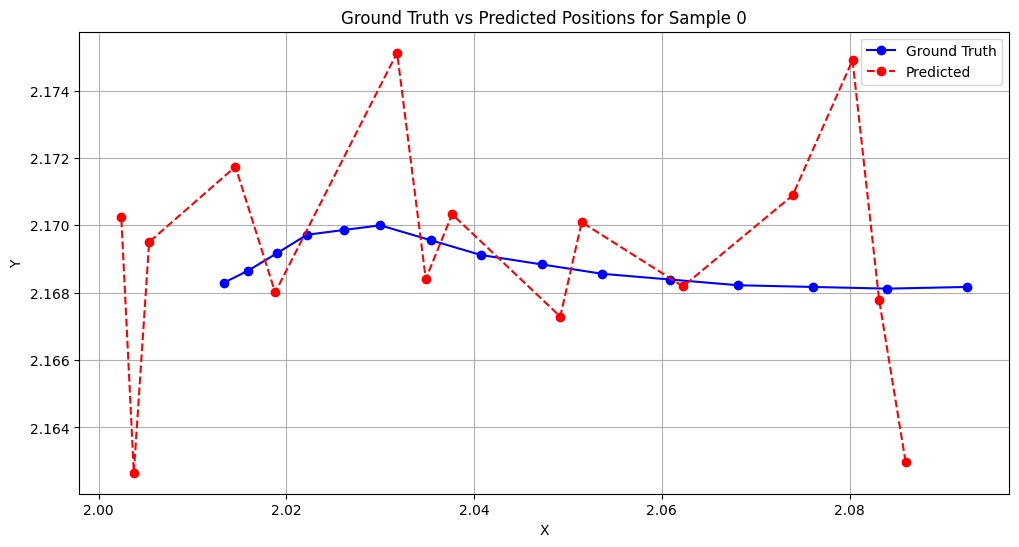

In [171]:
index = 0
predictions = run_imm_particle_filter_and_predict(ds_2d[0][index:]) 
plot_predictions(ds_2d[0][index:], predictions, sample_index=0)

# Interacting Multiple Models

In [29]:
# IMM (CV,CA)
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.kalman import IMMEstimator

def create_imm_estimator(dt, q, r, initial_state):
    state_dim = 9  # Use a consistent state dimension
    measurement_dim = 3

    # Create a KalmanFilter instance for constant velocity
    kf_cv = KalmanFilter(dim_x=state_dim, dim_z=measurement_dim)
    kf_cv.F = np.array([[1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0],
                        [0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0],
                        [0, 0, 1, 0, 0, dt, 0, 0, 0.5*dt**2],
                        [0, 0, 0, 1, 0, 0, dt, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, dt, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0, dt],
                        [0, 0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 1]])
    
    kf_cv.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0, 0]])
    kf_cv.P *= 10
    kf_cv.Q = np.eye(state_dim) * 0.1
    kf_cv.R = np.eye(measurement_dim) * 1.0
    kf_cv.x = np.hstack((initial_state[:6], np.zeros(3)))  # Pad with zeros to match the state dimension

    # Create a KalmanFilter instance for constant acceleration
    kf_ca = KalmanFilter(dim_x=state_dim, dim_z=measurement_dim)
    kf_ca.F = np.array([[1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0],
                        [0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0],
                        [0, 0, 1, 0, 0, dt, 0, 0, 0.5*dt**2],
                        [0, 0, 0, 1, 0, 0, dt, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, dt, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0, dt],
                        [0, 0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 1]])
    
    kf_ca.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0, 0]])
    kf_ca.P *= 10
    kf_ca.Q = np.eye(state_dim) * 0.1
    kf_ca.R = np.eye(measurement_dim) * 1.0
    kf_ca.x = initial_state

    # Define initial mode probabilities
    mu = np.array([0.5, 0.5])

    # Define Markov chain transition matrix
    M = np.array([[0.9, 0.1],
                  [0.1, 0.9]])

    # Create IMM Estimator
    return IMMEstimator([kf_cv, kf_ca], mu, M)

def run_imm_and_predict(batch_positions):

    batch_size, timesteps, _ = batch_positions.shape
    dt = 1.0
    q = 0.1
    r = 0.1
    
    predictions = np.zeros((batch_size, 15, 9))
    
    for i in range(batch_size):
        # Initial state (starting with the first position, estimated velocity, and zero acceleration)
        initial_position = batch_positions[i, 0]
        initial_velocity = (batch_positions[i, 1] - batch_positions[i, 0]) / dt
        initial_acceleration = np.zeros(3)
        initial_state = np.hstack((initial_position, initial_velocity, initial_acceleration))

        imm = create_imm_estimator(dt, q, r, initial_state)
        
        # Running the IMM estimator for the first 5 timesteps
        for t in range(5):
            z = batch_positions[i, t]
            imm.predict()
            imm.update(z)
            predictions[i, t] = imm.x
        
        # Predicting the next 10 timesteps without updating
        for t in range(5, 15):
            imm.predict()
            predictions[i, t] = imm.x

    return predictions

def plot_predictions_imm(ground_truth, predictions, sample_index):
    gt_x = ground_truth[sample_index, :, 0]
    gt_y = ground_truth[sample_index, :, 1]
    pred_x = predictions[sample_index, :, 0]
    pred_y = predictions[sample_index, :, 1]

    plt.plot(gt_x, gt_y, label='Ground Truth', marker='o')
    plt.plot(pred_x, pred_y, label='Prediction', marker='x')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()



In [52]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.kalman import IMMEstimator

def create_imm2_estimator(dt, q, r, omega_variance, initial_state):
    state_dim = 10  # Consistent state dimension across both models
    measurement_dim = 3

    # Create a KalmanFilter instance for Constant Velocity (CV) Model
    kf_cv = KalmanFilter(dim_x=state_dim, dim_z=measurement_dim)
    # State Transition Matrix for CV
    kf_cv.F = np.array([[1, 0, 0, dt, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, dt, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, dt, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0, 0, dt, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, dt, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0, dt, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # Zero acceleration
                        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # Zero acceleration
                        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # Zero acceleration
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]) # Turn rate constant
    
    kf_cv.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])
    kf_cv.P = np.eye(state_dim) * 10
    kf_cv.Q = np.eye(state_dim) * q
    kf_cv.R = np.eye(measurement_dim) * r
    kf_cv.x = initial_state.copy()
    kf_cv.x[9] = 0  # Zero turn rate for CV model

    # Create a KalmanFilter instance for Coordinated Turn (CT) Model
     # Create a KalmanFilter instance for Coordinated Turn (CT) Model
    kf_ct = KalmanFilter(dim_x=state_dim, dim_z=measurement_dim)
    
    # Initial turn rate (omega)
    omega = initial_state[9]  # Turn rate
    
    # Avoid division by zero for small omega
    if omega == 0:
        omega = 1e-5
    
    sin_omega_dt = np.sin(omega * dt)
    cos_omega_dt = np.cos(omega * dt)
    
    # State Transition Matrix for CT
    kf_ct.F = np.array([
        [1, 0, 0, sin_omega_dt/omega, 0, 0, (1 - cos_omega_dt)/omega, 0, 0, 0],
        [0, 1, 0, 0, sin_omega_dt/omega, 0, 0, (1 - cos_omega_dt)/omega, 0, 0],
        [0, 0, 1, 0, 0, dt, 0, 0, 0, 0],
        [0, 0, 0, cos_omega_dt, 0, 0, sin_omega_dt, 0, 0, 0],
        [0, 0, 0, 0, cos_omega_dt, 0, 0, sin_omega_dt, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, dt, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # Zero acceleration in x
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # Zero acceleration in y
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # Zero acceleration in z
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]   # Turn rate remains constant
    ])

    
    kf_ct.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])
    kf_ct.P = np.eye(state_dim) * 10
    kf_ct.Q = np.eye(state_dim) * q
    # Specifically, for the turn rate component
    # Assuming omega_variance is an additional hyperparameter
    kf_ct.Q[6, 6] = q * omega_variance
    kf_ct.Q[7, 7] = q * omega_variance
    kf_ct.Q[9, 9] = q * omega_variance  # Higher uncertainty in the turn rate

    kf_ct.R = np.eye(measurement_dim) * r
    kf_ct.x = initial_state.copy()

    # Define initial mode probabilities
    mu = np.array([0.5, 0.5])

    # Define Markov chain transition matrix
    M = np.array([[0.85, 0.15],  # High likelihood of staying in CV
               [0.15, 0.85]])  # High likelihood of staying in CT


    # Create IMM Estimator
    return IMMEstimator([kf_cv, kf_ct], mu, M)



def run_imm2_and_predict(batch_positions, q, r, omega_variance,P, M, dt):
    batch_size, timesteps, _ = batch_positions.shape
    
    predictions = np.zeros((batch_size, 15, 10))  # Assuming 10 state dimensions
    
    for i in range(batch_size):
        # Initial state estimation
        initial_position = batch_positions[i, 0]
        initial_velocity = (batch_positions[i, 1] - batch_positions[i, 0]) / dt
        initial_acceleration = np.zeros(2)
        initial_turn_rate = 0.0  # Assuming starting with no turn
        initial_state = np.hstack((initial_position, initial_velocity, initial_turn_rate, initial_acceleration))
        initial_state = np.hstack((initial_state, 0))  # Padding to match state dimension if necessary

        # Create IMM estimator with the provided hyperparameters
        imm = create_imm2_estimator(dt, q, r, omega_variance, initial_state)
        
        # Running the IMM estimator for the first 5 timesteps
        for t in range(5):
            z = batch_positions[i, t]
            imm.predict()
            imm.update(z)
            predictions[i, t] = imm.x
        
        # Predicting the next 10 timesteps without updating (no measurements)
        for t in range(5, 15):
            imm.predict()
            predictions[i, t] = imm.x

    return predictions


def plot_predictions_imm2(ground_truth, predictions, sample_index):
    gt_x = ground_truth[sample_index, :, 0]
    gt_y = ground_truth[sample_index, :, 1]
    pred_x = predictions[sample_index, :, 0]
    pred_y = predictions[sample_index, :, 1]

    plt.figure(figsize=(10, 6))
    plt.plot(gt_x, gt_y, label='Ground Truth', marker='o')
    plt.plot(pred_x, pred_y, label='Prediction', marker='x')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('IMM Tracking: Ground Truth vs Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()



In [10]:
import tensorflow as tf 
loaded = tf.data.experimental.load(
    "test_dataset"
)
def tf_dataset_to_numpy(tf_dataset):
    numpy_data = []
    for batch in tf_dataset.as_numpy_iterator():
        if batch[0].shape[0]==32:
            numpy_data.append(batch[0])
    return np.asarray(numpy_data)*100

# Convert the TensorFlow dataset to a numpy array
batch_positions2 = tf_dataset_to_numpy(loaded)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17404134898602437468
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17404134898602437468


In [3]:
index = 10
predictions = run_imm_and_predict(batch_positions2[0][index:])
plot_predictions_imm(batch_positions2[0][index:], predictions, sample_index=0)

NameError: name 'run_imm_and_predict' is not defined

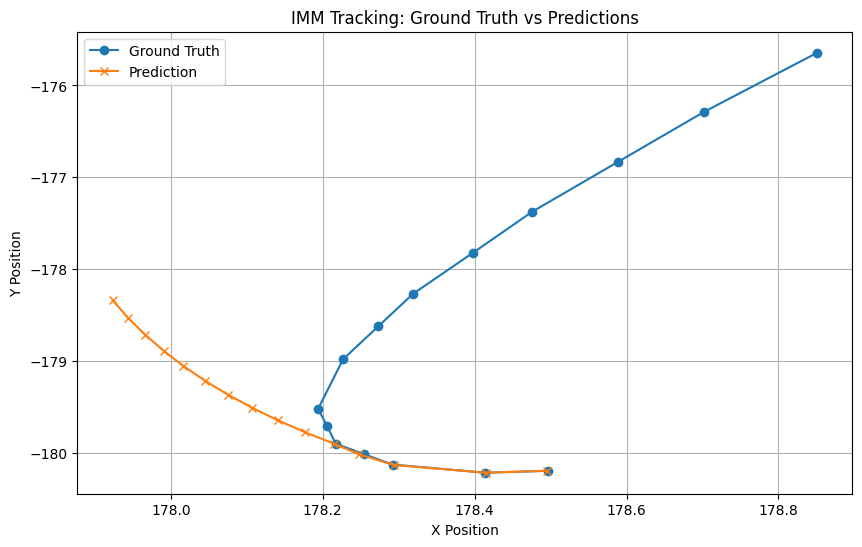

In [13]:
index = 10
predictions = run_imm2_and_predict(batch_positions2[0][index:])
plot_predictions_imm2(batch_positions2[0][index:], predictions, sample_index=0)

In [20]:
import numpy as np

def calculate_minADE(ground_truth, predictions):
    # Extract the position part from predictions (assuming position is the first 3 components)
    predicted_positions = predictions[:, :, :3]
    
    # Calculate the l2 distance between each point in the trajectory
    displacement_errors = np.linalg.norm(ground_truth - predicted_positions, axis=2)
    
    # Calculate the average displacement error
    minADE = np.min(np.mean(displacement_errors, axis=1))
    return minADE

def calculate_minFDE(ground_truth, predictions):
    # Extract the position part from predictions (assuming position is the first 3 components)
    predicted_positions = predictions[:, :, :3]
    
    # Calculate the l2 distance between the final positions
    final_displacement_errors = np.linalg.norm(ground_truth[:, -1] - predicted_positions[:, -1], axis=1)
    
    # Find the minimum final displacement error
    minFDE = np.min(final_displacement_errors)
    return minFDE


In [55]:
from itertools import product

# Define the hyperparameter space
q_values = [0.01, 0.1, 0.5]  # Focus more on increasing process noise
r_values = [0.001, 0.01, 0.1]  # Focus on reducing measurement noise
P_values = [1, 10, 100]  # Keep as is for now
M_values = [
    np.array([[0.85, 0.15], [0.15, 0.85]]),  # Slightly favoring the CT model
    np.array([[0.7, 0.3], [0.3, 0.7]]),
    np.array([[0.6, 0.4], [0.4, 0.6]])  # More aggressive favoring of CT model
]
dt_values = [0.2, 0.5, 1.0]  # Smaller time steps to capture slow turns
omega_variance_values = [0.01, 0.1, 1.0]  # Example values to explore

# Track the best hyperparameters and metrics
best_hyperparameters = None
best_minADE = float('inf')
best_minFDE = float('inf')

# Loop through all combinations of hyperparameters
for omega_variance in omega_variance_values:
    for q, r, P, M, dt in product(q_values, r_values, P_values, M_values, dt_values):
    
        # Run the IMM estimator with the current hyperparameters
        predictions = run_imm2_and_predict(batch_positions2[0][0:], q, r, omega_variance, P, M, dt)
        
        # Calculate metrics
        minADE = calculate_minADE(batch_positions2[0][0:], predictions)
        minFDE = calculate_minFDE(batch_positions2[0][0:], predictions)
        
        # Update the best hyperparameters if this combination is better
        if minADE < best_minADE or (minADE == best_minADE and minFDE < best_minFDE):
            best_minADE = minADE
            best_minFDE = minFDE
            best_hyperparameters = {'q': q, 'r': r, 'P': P, 'M': M, 'dt': dt, 'omega_variance': omega_variance}

# Output the best hyperparameters and corresponding metrics
print("Best Hyperparameters:", best_hyperparameters)
print("Best minADE:", best_minADE)
print("Best minFDE:", best_minFDE)


Best Hyperparameters: {'q': 0.01, 'r': 0.001, 'P': 1, 'M': array([[0.85, 0.15],
       [0.15, 0.85]]), 'dt': 1.0, 'omega_variance': 1.0}
Best minADE: 0.00721822100026231
Best minFDE: 0.02635017300837522


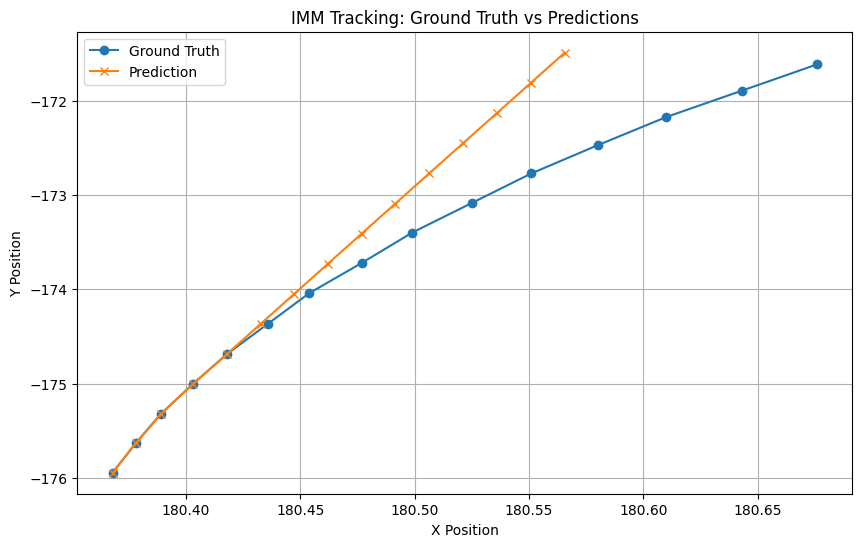

In [61]:
# After finding the best hyperparameters
index = 4
best_predictions = run_imm2_and_predict(batch_positions2[0][index:], 
                                        best_hyperparameters['q'], 
                                        best_hyperparameters['r'], 
                                        best_hyperparameters['omega_variance'],
                                        best_hyperparameters['P'], 
                                        best_hyperparameters['M'], 
                                        best_hyperparameters['dt'])

# Plot or evaluate the results
plot_predictions_imm2(batch_positions2[0][index:], best_predictions, sample_index=0)
